Abre uma imagem e transforma-a para binária usando o threshold

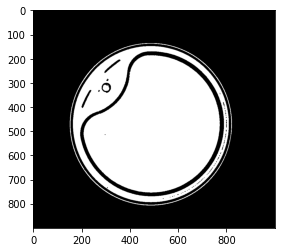

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte, invert, img_as_float
from skimage.filters import try_all_threshold, threshold_minimum
from skimage.morphology import binary_erosion

image = io.imread('https://raw.githubusercontent.com/guipiveti/rivet_dataset/master/Original/Fraturadas/frat%20(13).bmp')

image = image[50:950,0:1000]

thresh_min = threshold_minimum(image)
binary_image = image > thresh_min

binary_image = binary_erosion(binary_image)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.imshow(binary_image, cmap=plt.cm.gray)
plt.show()

Bounding rectangle: recorta a imagem

In [ ]:
min_x, max_x, min_y, max_y = 0, 0, 0, 0
for i in range(binary_image.shape[0]):
  if np.any(binary_image[i,:]):
    max_x = i
    if min_x == 0:
      min_x = i
for i in range(binary_image.shape[1]):
  if np.any(binary_image[:,i]):
    max_y = i
    if min_y == 0:
      min_y = i
print(min_x, max_x, min_y, max_y)

binary_image = binary_image[min_x:max_x,min_y:max_y]
image = image[min_x:max_x,min_y:max_y]


137 806 152 821


Encontra o disco maior, a tampa da lata

322


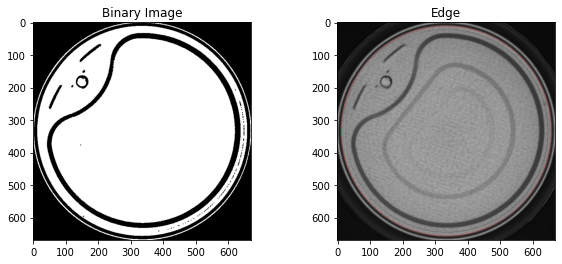

In [ ]:
edges = canny(binary_image, sigma=3)

hough_radii = np.arange(318, 326, 2)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent circle
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

ax[0].set_title('Binary Image')
ax[0].imshow(binary_image, cmap=plt.cm.gray)
image = color.gray2rgb(image)

for center_y, center_x, radius in zip(cy, cx, radii):
    print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=binary_image.shape)
    image[circy, circx] = (220, 20, 20)

ax[1].set_title('Edge')
ax[1].imshow(image, cmap=plt.cm.gray)

plt.show()

Cria-se uma região de interesse (ROI) em forma de anel onde sabe-se que o rebite está. A tranformada de Hough é usada para encontrar o rebite.

322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: FutureWarning: Pass-through of possibly RGB images in gray2rgb is deprecated. In version 0.19, input arrays will always be considered grayscale, even if the last dimension has length 3 or 4. To prevent this warning and ensure compatibility with future versions, detect RGB images outside of this function.


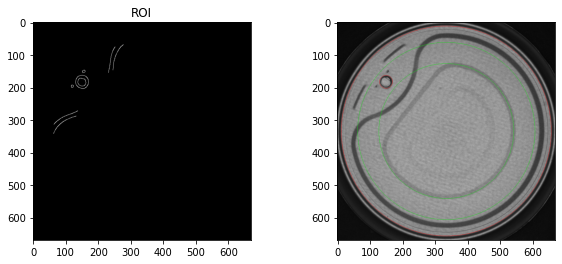

130 163 170 203


In [ ]:
for center_y, center_x, radius in zip(cy, cx, radii):
    print(radius)
    circy, circx = circle_perimeter(center_y, center_x, radius-115, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)
    circy, circx = circle_perimeter(center_y, center_x, radius-50, shape=binary_image.shape)
    image[circy, circx] = (20, 220, 20)

def get_ring(image, center, rmin, rmax):
    h,w = image.shape
    cy,cx = center
    g = np.copy(image)
    ys,xs = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
    rmin2 = rmin**2
    rmax2 = rmax**2
    dist2 = (xs-cx)**2 + (ys-cy)**2
    mask = (dist2 <= rmin2) | (dist2 >= rmax2)
    g[mask] = 0.0
    return g

center = (np.array(edges.shape)/2)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))

image_ring = get_ring(edges, center, radius-115, radius-50)

ax[0].set_title('ROI')
ax[0].imshow(image_ring, cmap=plt.cm.gray)


hough_radii = np.arange(20, 35, 2)
hough_res = hough_circle(image_ring, hough_radii)

accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=1)

image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius,
                                    shape=image.shape)
    image[circy, circx] = (220, 20, 20)
    ax[1].imshow(image, cmap=plt.cm.gray)
    plt.show()

    # Gets ROI of the rivet
    min_x = center_x - radius
    max_x = center_x + radius
    min_y = center_y - radius
    max_y = center_y + radius

    print(min_x, min_y, max_x, max_y)
    
    binary_image = binary_image[min_y:max_y,min_x:max_x]
    image = image[min_y:max_y,min_x:max_x]


ROI do rebite:

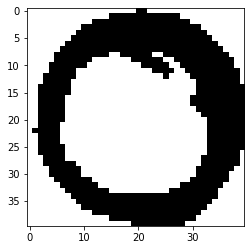

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(binary_image, cmap=plt.cm.gray)

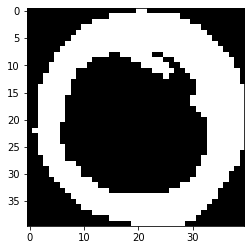

In [ ]:
binary_image = invert(binary_image)
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(binary_image, cmap=plt.cm.gray)

Usa-se uma máscara para recortar apenas o rebite:

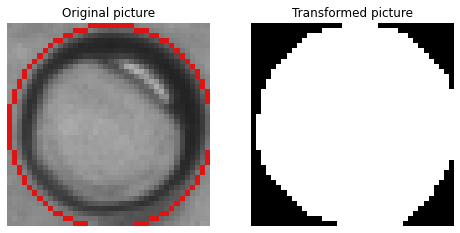

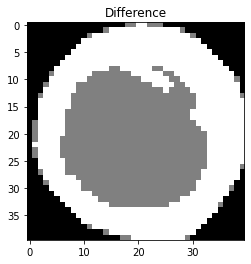

<Figure size 432x288 with 0 Axes>

In [ ]:
from skimage.morphology import convex_hull_image

chull = convex_hull_image(binary_image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].set_axis_off()

chull_diff = img_as_float(chull.copy())
chull_diff[binary_image] = 2

fig, ax = plt.subplots()
ax.imshow(chull_diff, cmap=plt.cm.gray)
ax.set_title('Difference')
plt.show()

plt.tight_layout()
plt.show()


Separa-se a image em regiões e usa-se apenas a do centro (rebite em si):

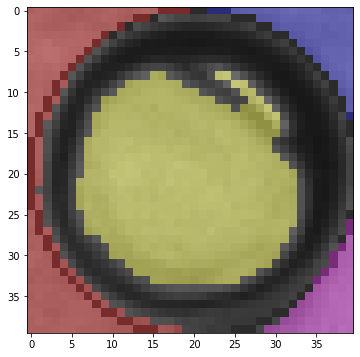

In [ ]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
binary_image = invert(binary_image)

labels = label(binary_image)

image_label_overlay = label2rgb(labels, image=image, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)


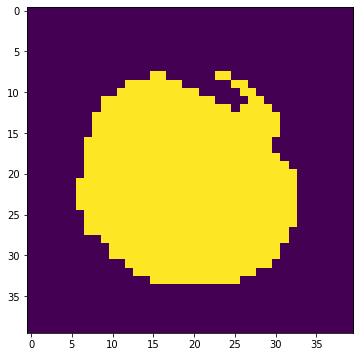

In [ ]:
from skimage.segmentation import clear_border
# remove artifacts connected to image border
cleared = clear_border(labels)

image_label_overlay = label2rgb(labels, image=image, bg_label=0, bg_color=None, kind='overlay')
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(cleared)

545


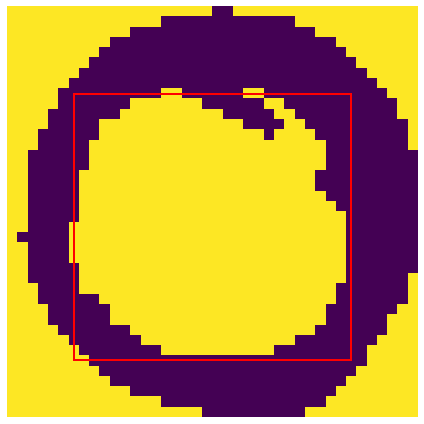

In [ ]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(binary_image)

for region in regionprops(cleared):
    print(region.area)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()